Some Visuasization based on location history
========

Check it out https://accounts.google.com/ServiceLogin?service=backup to download your location history archive as a .geojson file  
This notebook is partially based on http://beneathdata.com/how-to/visualizing-my-location-history/ work

In [3]:
import os
os.getcwd()

'/Users/pedrohserrano/data-visualization/location-history'

In [4]:
import numpy as np
import pandas as pd
import json
import datetime
import mpl_toolkits
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
import fiona
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
with open('/Users/pedrohserrano/google-takeout/Ubicaciones/Historialdeubicaciones.json', 'r') as fh:
    raw = json.loads(fh.read())

In [6]:
ld = pd.DataFrame(raw['locations'])
del raw #free up some memory
# convert to typical units
ld['latitudeE7'] = ld['latitudeE7']/float(1e7) 
ld['longitudeE7'] = ld['longitudeE7']/float(1e7)
ld['timestampMs'] = ld['timestampMs'].map(lambda x: float(x)/1000) #to seconds
ld['datetime'] = ld.timestampMs.map(datetime.datetime.fromtimestamp)
# Rename fields based on the conversions we just did
ld.rename(columns={'latitudeE7':'latitude', 'longitudeE7':'longitude', 'timestampMs':'timestamp'}, inplace=True)
ld = ld[ld.accuracy < 1000] #Ignore locations with accuracy estimates over 1000m
ld.reset_index(drop=True, inplace=True)

In [9]:
ld.head()

,accuracy,activitys,altitude,heading,latitude,longitude,timestamp,velocity,datetime
0,53,NaN,NaN,NaN,20.439290,-87.287720,1.414820e+09,NaN,2014-10-31 23:35:19.154999
1,58,NaN,NaN,NaN,20.439363,-87.287705,1.414820e+09,NaN,2014-10-31 23:34:19.184000
2,67,NaN,NaN,NaN,20.439250,-87.287705,1.414820e+09,NaN,2014-10-31 23:33:14.096999
3,66,"[{'activities': [{'type': 'still', 'confidence...",NaN,NaN,20.439270,-87.287700,1.414820e+09,NaN,2014-10-31 23:32:05.950000
4,55,NaN,NaN,NaN,20.439357,-87.287708,1.414820e+09,NaN,2014-10-31 23:31:05.903000


We need to download the shapefile [here](http://www.gadm.org/country)

In [11]:
shapefilename = '/Users/pedrohserrano//Users/pedrohserrano/geo-files/MEX_adm_shp/MEX_adm2'
shp = fiona.open(shapefilename+'.shp')
shp

<open Collection '/Users/pedrohserrano/data-visualization/location-history/MEX_adm_shp/MEX_adm2.shp:MEX_adm2', mode 'r' at 0x117885128>

In [56]:
coords = shp.bounds
coords ##centre of map
##coords = (-98,18,-100,20) DF

(-118.36888885498041,
 14.532917022705135,
 -86.71013641357423,
 32.71804046630862)

In [57]:
shp.close()

In [58]:
w, h = coords[2] - coords[0], coords[3] - coords[1]
extra = 0
print(w,h)

31.65875244140618 18.185123443603487


In [59]:
m = Basemap(
    projection='tmerc', ellps='WGS84',
    lon_0=np.mean([coords[0], coords[2]]),
    lat_0=np.mean([coords[1], coords[3]]),
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - (extra * h), 
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + (extra * h),
    resolution='i',  suppress_ticks=True)

In [60]:
type(m) #prove if it works

mpl_toolkits.basemap.Basemap

In [61]:
_out = m.readshapefile(shapefilename, name='MEX_adm2', drawbounds=False, color='none', zorder=2)
print (_out)

(1853, 5, [-118.36888885498041, 14.532917022705135, 0.0, 0.0], [-86.71013641357423, 32.71804046630862, 0.0, 0.0])


In [62]:
# define map colors
land_color = '#fee6ce'
water_color = '#9ecae1'
coastline_color = '#FFFFFF'
border_color = 'None'
meridian_color = 'None'
marker_fill_color = '#cc3300'
marker_edge_color = 'None'

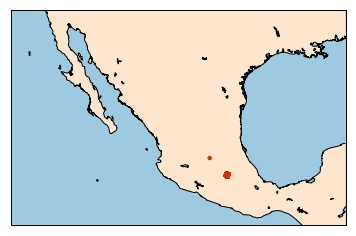

In [63]:
m.drawmapboundary(fill_color='#9ecae1')
m.fillcontinents(color='#fee6ce',lake_color='#9ecae1')
m.drawcoastlines()

# project our points from each dataset then concatenate and scatter plot them
x, y = m(ld['longitude'].values, ld['latitude'].values)
m.scatter(x, y, s=20, color=marker_fill_color, edgecolor=marker_edge_color, alpha=1, zorder=3)

# show the map
#plt.savefig('images/foursquare_checkins_map.png', dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

Well.. we have to improve this